In [185]:
import numpy as np
import pandas as pd
import yaml
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import seaborn as sns

# Import

First we open a file containing a dictionary of columns and associated data types generated in `../../optimize/`, then we read input file.

In [186]:
with open('../input/dtypes.yaml', 'r') as yamlfile:
    column_types = yaml.load(yamlfile)

read_csv_opts = {'sep': '|',
                 'quotechar': '"',
                 'compression': 'gzip',
                 'encoding': 'utf-8',
                 'dtype': column_types,
                 'parse_dates': ['MissionDate'],
                 'infer_datetime_format': True}

df = pd.read_csv('../input/ice-air.csv.gz', **read_csv_opts)

df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1763020 entries, 0 to 1763019
Data columns (total 43 columns):
Status                  category
Sex                     category
Convictions             category
GangMember              category
ClassLvl                float32
Age                     float32
MissionDate             datetime64[ns]
MissionNumber           uint32
PULOC                   category
DropLoc                 category
StrikeFromList          float32
ReasonStruck            category
R-T                     category
Code                    category
CountryOfCitizenship    category
Juvenile                bool
MissionWeek             uint8
MissionQuarter          uint8
MissionYear             uint16
MissionMonth            uint8
Criminality             category
FamilyUnitFlag          float32
UnaccompaniedFlag       float32
AlienMasterID           uint32
MissionID               uint16
air_AirportID           float32
air_AirportName         category
air_City         

# By country of citizenship

In [187]:
nationality = 'CAMBODIA'

In [188]:
nationality_df = df[df['CountryOfCitizenship'] == nationality.upper()]

In [189]:
nationality_df['air_AirportName'].value_counts().head(10)

Phoenix-Mesa-Gateway Airport                      711
Alexandria International Airport                  600
El Paso International Airport                     188
Harrisburg International Airport                  153
San Diego International Airport                   136
Boeing Field King County International Airport    109
Metropolitan Oakland International Airport         95
Miami International Airport                        60
Southern California Logistics Airport              57
Newark Liberty International Airport               35
Name: air_AirportName, dtype: int64

In [190]:
nationality_df['air2_AirportName'].value_counts().head(10)

Phoenix-Mesa-Gateway Airport                      707
Alexandria International Airport                  626
San Diego International Airport                   188
El Paso International Airport                     171
Harrisburg International Airport                  125
Phnom Penh International Airport                  120
Boeing Field King County International Airport    117
Metropolitan Oakland International Airport         73
Miami International Airport                        58
Newark Liberty International Airport               30
Name: air2_AirportName, dtype: int64

In [191]:
nationality_df.set_index('MissionDate', inplace=True)

In [192]:
groupby = nationality_df.groupby(['CountryOfCitizenship', 'MissionDate', 'R-T', 'PULOC', 'DropLoc'])

In [193]:
table = groupby['AlienMasterID'].nunique().reset_index(name='AlienMasterIDCount')
table['MissionIDCount'] = groupby['MissionID'].nunique().reset_index(name='MissionIDCount')['MissionIDCount']

In [194]:
removals = table[table['R-T'] == 'R'].copy()
transfers = table[table['R-T'] == 'T'].copy()

In [195]:
removals.set_index('MissionDate', inplace=True)
transfers.set_index('MissionDate', inplace=True)

In [196]:
weekly_removals = removals['AlienMasterIDCount'].resample('W').sum()
weekly_transfers = transfers['AlienMasterIDCount'].resample('W').sum()
monthly_removals = removals['AlienMasterIDCount'].resample('M').sum()
monthly_transfers = transfers['AlienMasterIDCount'].resample('M').sum()
monthly_removal_flights = removals['MissionIDCount'].resample('M').sum()
monthly_transfers_flights = transfers['MissionIDCount'].resample('M').sum()
annual_removals = removals['AlienMasterIDCount'].resample('AS-OCT').sum()
annual_transfers = transfers['AlienMasterIDCount'].resample('AS-OCT').sum()
annual_removal_flights = removals['MissionIDCount'].resample('AS-OCT').sum()
annual_transfer_flights = transfers['MissionIDCount'].resample('AS-OCT').sum()

In [197]:
annual_removals

MissionDate
2015-10-01     2
2016-10-01    28
2017-10-01    90
Freq: AS-OCT, Name: AlienMasterIDCount, dtype: int64

In [198]:
removals.reset_index(inplace=True, drop=False)
transfers.reset_index(inplace=True, drop=False)

In [199]:
removals.head(10)

,MissionDate,CountryOfCitizenship,R-T,PULOC,DropLoc,AlienMasterIDCount,MissionIDCount
0,2016-01-05,CAMBODIA,R,KIWA,VDPP,2,1
1,2017-03-28,CAMBODIA,R,KAEX,VDPP,5,1
2,2017-04-18,CAMBODIA,R,KIWA,VDPP,8,1
3,2017-05-02,CAMBODIA,R,KIWA,VDPP,8,1
4,2017-05-15,CAMBODIA,R,KIWA,VDPP,7,1
5,2017-12-18,CAMBODIA,R,KELP,VDPP,9,1
6,2018-02-28,CAMBODIA,R,KIWA,VDPP,8,1
7,2018-04-03,CAMBODIA,R,KELP,VDPP,43,1
8,2018-08-20,CAMBODIA,R,KELP,VDPP,30,1


In [200]:
transfers.head()

,MissionDate,CountryOfCitizenship,R-T,PULOC,DropLoc,AlienMasterIDCount,MissionIDCount
0,2010-10-04,CAMBODIA,T,KMDT,KAEX,1,1
1,2010-10-12,CAMBODIA,T,KMDT,KAEX,3,1
2,2010-10-15,CAMBODIA,T,KBFL,KIWA,1,1
3,2010-10-15,CAMBODIA,T,KOAK,KIWA,2,1
4,2010-10-16,CAMBODIA,T,KIWA,KBFI,2,1


In [201]:
# transfers.to_csv(f'../output/{nationality.lower()}_transfers.csv.gz', compression='gzip', sep='|', index=False)
# removals.to_csv(f'../output/{nationality.lower()}_repatriations.csv.gz', compression='gzip', sep='|', index=False)

In [202]:
removals.set_index('MissionDate', inplace=True)

In [203]:
transfers.set_index('MissionDate', inplace=True)

In [204]:
r_cum = removals['AlienMasterIDCount'].cumsum()
t_cum = transfers['AlienMasterIDCount'].cumsum()

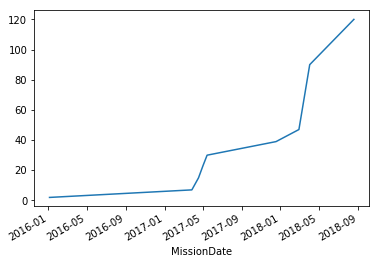

In [205]:
r_cum.plot();


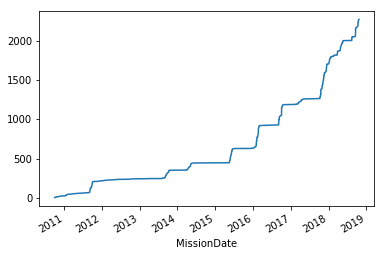

In [206]:
t_cum.plot();

In [207]:
g = nationality_df.groupby([pd.Grouper(freq='AS-OCT', sort=True), 'R-T', 'air_AirportName', 'air2_AirportName', 'air2_Country'])[['AlienMasterID', 'MissionID']].nunique()
g.reset_index(inplace=True)
removal_dropoff_airports = g[g['R-T'] == 'R'].copy()
transfer_dropoff_airports = g[g['R-T'] == 'T'].copy()

In [208]:
removal_dropoff_airports.sort_values(by=['MissionDate', 'AlienMasterID'], ascending=[True, False], inplace=True)
transfer_dropoff_airports.sort_values(by=['MissionDate', 'AlienMasterID'], ascending=[True, False], inplace=True)

In [209]:
removal_dropoff_airports.head(10)

,MissionDate,R-T,air_AirportName,air2_AirportName,air2_Country,AlienMasterID,MissionID
108,2015-10-01,R,Phoenix-Mesa-Gateway Airport,Phnom Penh International Airport,Cambodia,2,1
145,2016-10-01,R,Phoenix-Mesa-Gateway Airport,Phnom Penh International Airport,Cambodia,23,3
144,2016-10-01,R,Alexandria International Airport,Phnom Penh International Airport,Cambodia,5,1
170,2017-10-01,R,El Paso International Airport,Phnom Penh International Airport,Cambodia,82,3
171,2017-10-01,R,Phoenix-Mesa-Gateway Airport,Phnom Penh International Airport,Cambodia,8,1


In [210]:
transfer_dropoff_airports.head(10)

,MissionDate,R-T,air_AirportName,air2_AirportName,air2_Country,AlienMasterID,MissionID
23,2010-10-01,T,San Diego International Airport,Phoenix-Mesa-Gateway Airport,USA,40,7
21,2010-10-01,T,Phoenix-Mesa-Gateway Airport,San Diego International Airport,USA,29,6
14,2010-10-01,T,Metropolitan Oakland International Airport,Phoenix-Mesa-Gateway Airport,USA,9,8
19,2010-10-01,T,Phoenix-Mesa-Gateway Airport,Boeing Field King County International Airport,USA,9,6
20,2010-10-01,T,Phoenix-Mesa-Gateway Airport,Metropolitan Oakland International Airport,USA,9,4
24,2010-10-01,T,Valley International Airport,Phoenix-Mesa-Gateway Airport,USA,9,3
1,2010-10-01,T,Alexandria International Airport,Phoenix-Mesa-Gateway Airport,USA,8,1
6,2010-10-01,T,Harrisburg International Airport,Alexandria International Airport,USA,8,4
7,2010-10-01,T,Harrisburg International Airport,Valley International Airport,USA,6,1
11,2010-10-01,T,Meadows Field,Phoenix-Mesa-Gateway Airport,USA,6,6


In [211]:
# removal_dropoff_airports.to_csv(f'../output/{nationality}_repatriation_dropoff_airports.csv')
# transfer_dropoff_airports.to_csv(f'../output/{nationality}_transfer_dropoff_airports.csv')

In [212]:
pivot = pd.pivot_table(data=removal_dropoff_airports,
                       index='MissionDate',
                       columns='air2_Country',
                       values='MissionID',
                       aggfunc=np.sum,
                       fill_value=0)

In [213]:
pivot = pivot.reindex(pivot.sum().sort_values(ascending=False).index, axis=1)

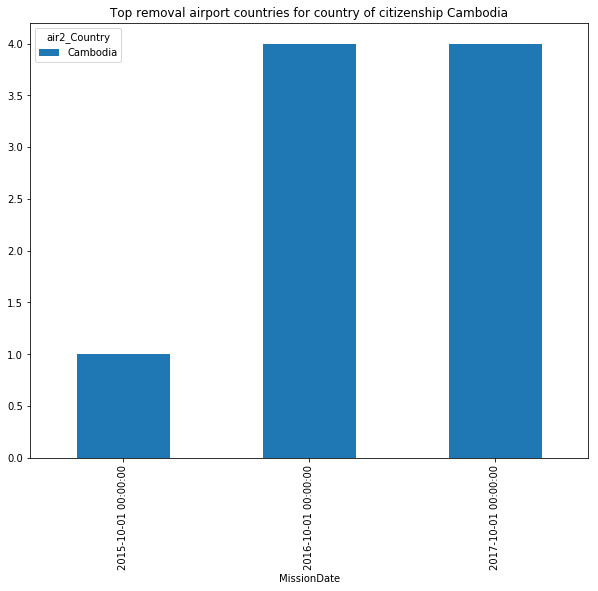

In [214]:
title = f"Top removal airport countries for country of citizenship {nationality.title()}"
fig = pivot.plot(kind='bar', stacked=True, figsize=(10, 8), title=title)

## Juveniles only

In [215]:
# Uses same groupby as above
juv_table = groupby['Juvenile'].sum().reset_index(name='Juveniles')

In [216]:
juv_removals = juv_table[juv_table['R-T'] == 'R'].copy()
juv_transfers = juv_table[juv_table['R-T'] == 'T'].copy()

In [217]:
juv_removals.set_index('MissionDate', inplace=True)

In [218]:
juv_r_cum = juv_removals['Juveniles'].cumsum()

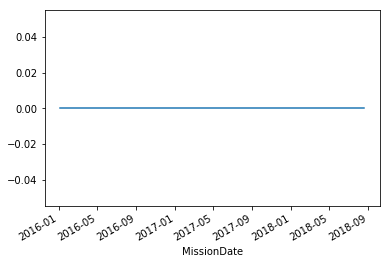

In [219]:
juv_r_cum.plot()

In [220]:
removals['Juveniles'] = juv_removals['Juveniles']

In [221]:
removals['JuvPercent'] = juv_removals['Juveniles'] / removals['AlienMasterIDCount']

In [222]:
removals.tail(20)

,CountryOfCitizenship,R-T,PULOC,DropLoc,AlienMasterIDCount,MissionIDCount,Juveniles,JuvPercent
MissionDate,,,,,,,,
2016-01-05,CAMBODIA,R,KIWA,VDPP,2,1,False,0.0
2017-03-28,CAMBODIA,R,KAEX,VDPP,5,1,False,0.0
2017-04-18,CAMBODIA,R,KIWA,VDPP,8,1,False,0.0
2017-05-02,CAMBODIA,R,KIWA,VDPP,8,1,False,0.0
2017-05-15,CAMBODIA,R,KIWA,VDPP,7,1,False,0.0
2017-12-18,CAMBODIA,R,KELP,VDPP,9,1,False,0.0
2018-02-28,CAMBODIA,R,KIWA,VDPP,8,1,False,0.0
2018-04-03,CAMBODIA,R,KELP,VDPP,43,1,False,0.0
2018-08-20,CAMBODIA,R,KELP,VDPP,30,1,False,0.0


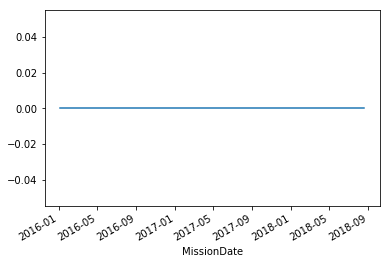

In [223]:
removals['JuvPercent'].plot();

In [224]:
removals[removals['JuvPercent'] > .5]

,CountryOfCitizenship,R-T,PULOC,DropLoc,AlienMasterIDCount,MissionIDCount,Juveniles,JuvPercent
MissionDate,,,,,,,,


In [225]:
removals['Juveniles'].max()

False

In [226]:
removals[removals['Juveniles'] > 20]

,CountryOfCitizenship,R-T,PULOC,DropLoc,AlienMasterIDCount,MissionIDCount,Juveniles,JuvPercent
MissionDate,,,,,,,,


# KBFI only

In [227]:
airport = 'KBFI'

In [228]:
airport_removals = removals[removals['PULOC'] == airport]

In [229]:
airport_transfers = transfers[transfers['PULOC'] == airport]

In [230]:
airport_weekly_removals = airport_removals['AlienMasterIDCount'].resample('W').nunique()
airport_weekly_transfers = airport_transfers['AlienMasterIDCount'].resample('W').nunique()
airport_monthly_removals = airport_removals['AlienMasterIDCount'].resample('M').nunique()
airport_monthly_transfers = airport_transfers['AlienMasterIDCount'].resample('M').nunique()
airport_monthly_removal_flights = airport_removals['MissionIDCount'].resample('M').nunique()
airport_monthly_transfers_flights = airport_transfers['MissionIDCount'].resample('M').nunique()
airport_annual_removals = airport_removals['AlienMasterIDCount'].resample('AS-OCT').nunique()
airport_annual_transfers = airport_transfers['AlienMasterIDCount'].resample('AS-OCT').nunique()
airport_annual_removal_flights = airport_removals['MissionIDCount'].resample('AS-OCT').nunique()
airport_annual_transfer_flights = airport_transfers['MissionIDCount'].resample('AS-OCT').nunique()

In [231]:
airport_annual_removals

Series([], Freq: AS-OCT, Name: AlienMasterIDCount, dtype: int64)

In [232]:
airport_annual_transfers

MissionDate
2010-10-01    1
2011-10-01    0
2012-10-01    1
2013-10-01    2
2014-10-01    1
2015-10-01    2
2016-10-01    1
2017-10-01    5
Freq: AS-OCT, Name: AlienMasterIDCount, dtype: int64